# Important! Read Me!

This notebook requires a paid OpenAI API account to run. It cost about 25 cents to execute the script. If you have an API key, you can set it up following [these instructions](https://platform.openai.com/docs/quickstart). You might be able to make it cheaper by doing more queries per call, but I was worried about maximum length.

In [1]:
from pyprojroot import here
import sys
sys.path.insert(0, str(here()))

import pandas as pd
import yaml
import geopandas as gpd
from laos_gggi import load_emdat_data, load_shapefile
import matplotlib.pyplot as plt
from laos_gggi.plotting import configure_plot_style
from geopy.geocoders import Nominatim
import numpy as np

configure_plot_style()
geolocator = Nominatim(user_agent="laos_gggi")
emdat = load_emdat_data()

In [ ]:
queries = []
for idx, row in emdat['df_raw_filtered_adj'].iterrows():
    queries.append(f'ID:{idx}\nCountry:{row.Country}\nRegion:{row.Region}\nLocation:{row.Location}')

In [ ]:
n_queries = len(queries)
n_queries

In [ ]:
from openai import OpenAI
client = OpenAI()

SYSTEM_PROMPT = {"role": "system",
                 "content": '''You are a simulated geography lookup system. As input, you take descriptions of places, potentially many places, potentially in a very messy format. As output, return a YAML file with the ID as a key, then numerical subkeys, one for each likely location described by provided data, starting with zero. If a reasonable person would believe there are multiple locations, the data is split into sub-locations. For each entry, the YAML returns the most descriptive, most proximate location name as a string, along with its approximate latitude and longitude as floats'''}
EXAMPLE_EXCHANGE = [{
            "role": "user",
            "content": '''ID: 26420
Country: Chile
Region: Americas
Location: Viña del Mar City, Quilpué City (Marga Marga Province; Valparaíso Region); O'Higgins, Maule, Ñuble, Los Ríos, Arucania, Aysén regions'''
        },
        {
            "role":"assistant",
            "content":'''
            26420:
  0:
    name: "Viña del Mar City, Marga Marga Province, Valparaíso Region, Chile"
    lat: -33.0245
    long: -71.5518
  1:
    name: "Quilpué City, Marga Marga Province, Valparaíso Region, Chile"
    lat: -33.0493
    long: -71.4417
  2:
    name: "O'Higgins Region, Chile"
    lat: -34.5754
    long: -70.9727
  3:
    name: "Maule Region, Chile"
    lat: -35.4266
    long: -71.6554
  4:
    name: "Ñuble Region, Chile"
    lat: -36.7226
    long: -71.9577
  5:
    name: "Los Ríos Region, Chile"
    lat: -39.8088
    long: -72.7370
  6:
    name: "Arucania Region, Chile"
    lat: -38.7406
    long: -72.5903
  7:
    name: "Aysén Region, Chile"
    lat: -45.7373
    long: -72.0695
            '''
        }]

## Query GPT

Uncomment this cell to actually query ChatGPT

In [5]:
# gpt_outputs = []

# for i in range(n_queries, 10):
#     idx = slice(i, i + 10)
#     print(idx)
#     input_str = '\n'.join(queries[idx])
#     completion = client.chat.completions.create(
#         model="gpt-4o-mini",
#         messages=[SYSTEM_PROMPT,
#                   *EXAMPLE_EXCHANGE,
#                   {
#                       "role": "user",
#                       "content": input_str
#                   }
#         ]
#     )
#     gpt_outputs.append(completion.choices[0].message)

### Post-process GPT outputs

Simple first pass, remove the yaml tags and remove spaces from negative numbers (GPT returns `- 9` instead of `-9`)

In [6]:
# import re

# def process_output(x):
#     msg = str(x.content)
#     msg = re.sub('\- (\d*)', '-\g<0>', msg)
#     return msg.replace('```yaml', '').replace('```', '').strip()

# res = list(map(process_output, gpt_outputs))

## Save raw data 

Any errors were fixed by hand in the file, so that part isn't reproducable. ChatGPT spewed out nonsense some percentage of the time. This might be better if you use `gpt-4o` instead of `gpt-4o-mini`.

In [7]:
# with open(here('data/locations.yaml'), 'a') as file:
#     for chunk in res:
#         file.write(chunk)
#         file.write('\n')

# Load data

After all noise is removed from the `locations.yaml` written above, it can be loaded. If this is already done, you can just load the CSV that was created.

In [2]:
# with open(here('data/locations.yaml'), 'r') as file:
#     locs = yaml.safe_load(file)
    
# loc_dfs = []
# for idx, data in locs.items():
#     if list(data.keys())[0] != 0:
#         data = {0: data}
#     temp = pd.DataFrame(data)
#     temp.loc['idx'] = idx
#     temp = (temp.T
#                 .reset_index()
#                 .rename(columns={'index':'location_id', 
#                                  'idx':'emdat_index'})
#                 .set_index(['emdat_index', 'location_id'])
#                 .assign(lat = lambda x: x.lat.astype(float),
#                         long = lambda x: x.long.astype(float))
#            )
#     loc_dfs.append(temp)
# loc_df = pd.concat(loc_dfs)

# loc_df.to_csv(here('location_data_for_emdat.csv'))

loc_df = pd.read_csv(here('location_data_for_emdat.csv'), index_col=['emdat_index', 'location_id'])

## Spot check some results

In [3]:
n_to_check = 10
to_check = loc_df.sample(n_to_check).T.to_dict()

In [4]:
check_dict = {}
for key, d in to_check.items():
    check_dict[key] = d.copy()
    for sub_dict in d.values():
        lat = d['lat']
        lon = d['long']
        
        # Do a geo-lookup on the lat-long that GPT gave us, check if the address matches
        location = geolocator.reverse(f"{lat},{lon}")
        check_dict[key]['geopy'] = location

In [5]:
pd.DataFrame(check_dict).T.assign(address = lambda x: x.geopy.map(lambda y: y.address if y is not None else None))

,,name,lat,long,geopy,address
12746,6,"Saint Ann, Jamaica",18.4462,-77.2245,"(Bamboo - Priory Road, Plantation Village, Tan...","Bamboo - Priory Road, Plantation Village, Tang..."
19046,2,"Victoria, Australia",-37.8136,144.9631,"(260, Elizabeth Street, East End Theatre Distr...","260, Elizabeth Street, East End Theatre Distri..."
23096,2,"Guizhou, China",26.744,106.4995,"(百花湖镇, 贵阳市, 贵州省, 中国, (26.6883995, 106.5215544))","百花湖镇, 贵阳市, 贵州省, 中国"
20092,4,"Gilling West, North Yorkshire, England, United...",54.5008,-1.6828,"(Aldbrough, Aldbrough St John, North Yorkshire...","Aldbrough, Aldbrough St John, North Yorkshire,..."
15350,5,"Region IV (Southern Tagalog), Philippines",13.9781,121.0687,"(Lumang Lipa, Mataasnakahoy, Batangas, Calabar...","Lumang Lipa, Mataasnakahoy, Batangas, Calabarz..."
21722,11,"Darrang District, Assam, India",26.6417,92.3112,"(Oraog, Mazbat tehsil, Udalguri, Assam, 784114...","Oraog, Mazbat tehsil, Udalguri, Assam, 784114,..."
18624,5,"Mahottari District, Nepal",26.7103,85.6921,"(Pariharpur, Parihar, Sitamarhi, Bihar, 847253...","Pariharpur, Parihar, Sitamarhi, Bihar, 847253,..."
22232,6,"Maca, Caylloma Province, Arequipa Region, Peru",-15.7075,-71.5732,"(Achaculli, Chivay, Caylloma, Arequipa, Perú, ...","Achaculli, Chivay, Caylloma, Arequipa, Perú"
20799,2,"Likiep Atoll, Marshall Islands",8.3828,169.2675,None,None
7187,3,"Managua, Nicaragua",12.625,-86.7504,"(Bella Vista, Telica, León, 22400, Nicaragua, ...","Bella Vista, Telica, León, 22400, Nicaragua"


### Merge with emdat

In [6]:
cols = ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'disaster_class', 'ISO', 'Start_Year', 'Latitude', 'Longitude']
joined_df = pd.merge(loc_df.reset_index(), 
                     emdat['df_raw_filtered_adj'].reset_index(), 
                     left_on='emdat_index',
                     right_on='index',
                     how='outer')

joined_df = (joined_df.assign(emdat_index = lambda x: x.emdat_index.fillna(x['index']),
              location_id = lambda x: x.location_id.fillna(0),
             lat = lambda x: x.lat.fillna(x.Latitude),
             long = lambda x: x.long.fillna(x.Longitude))
     .drop(columns=['index', 'Latitude', 'Longitude'])
     .set_index(['emdat_index', 'location_id']))

## Visualize results

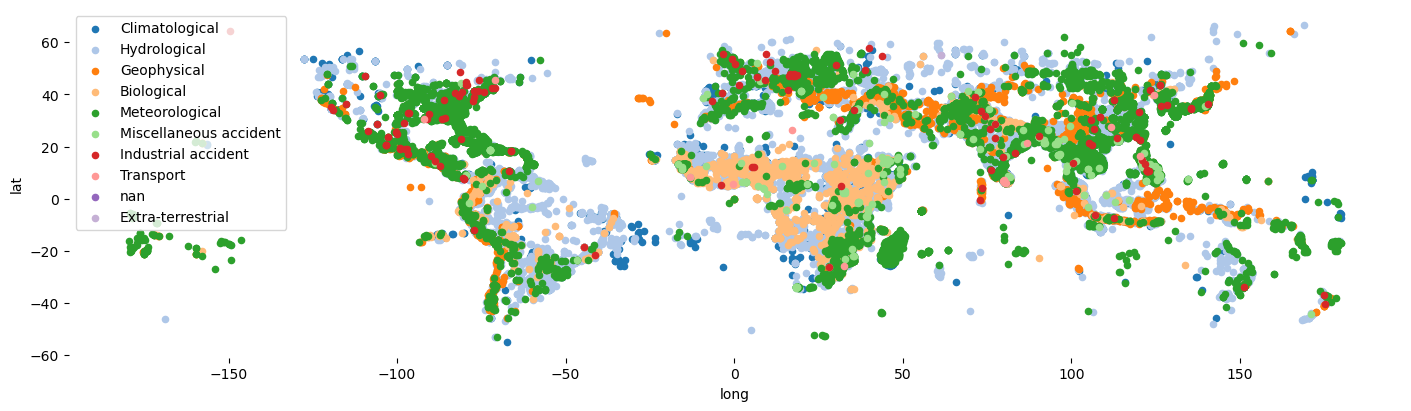

In [7]:
fig, ax = plt.subplots()
for i, group in enumerate(joined_df['Disaster Subgroup'].unique()):
    joined_df.query('`Disaster Subgroup` == @group').plot.scatter(x='long', y='lat', ax=ax, label=group,
                                                          color=plt.color_sequences['tab20'][i])

# Country verification

In [91]:
#Load world bank shapefiles
world_shapefiles = load_shapefile('world', repair_ISO_codes=True, force_reload=True)

world_shapefiles = world_shapefiles.rename(columns={"ISO_A3": "WB_ISO"})

Extracting C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\wb_countries_admin0_10m


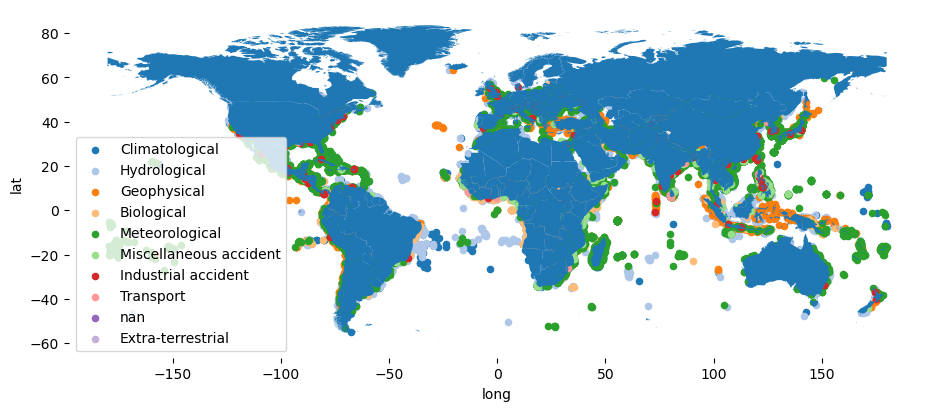

In [92]:
fig, ax = plt.subplots()
for i, group in enumerate(joined_df['Disaster Subgroup'].unique()):
    joined_df.query('`Disaster Subgroup` == @group').plot.scatter(x='long', y='lat', ax=ax, label=group,
                                                          color=plt.color_sequences['tab20'][i])

world_shapefiles.plot(ax=ax);

In [93]:
#Join the disaster coordinates with their respective country shapefiles
joined_df_geo = gpd.GeoDataFrame(
                joined_df, geometry=gpd.points_from_xy(joined_df["long"], joined_df["lat"]), crs="EPSG:4326"
            )

country_verification = joined_df_geo.sjoin(
                world_shapefiles, how="left", predicate="intersects")

In [94]:
print("There are " + 
    str(country_verification.query('WB_ISO.isna()').shape[0]) + " disasters outside country shapefiles" ) 

There are 3286 disasters outside country shapefiles


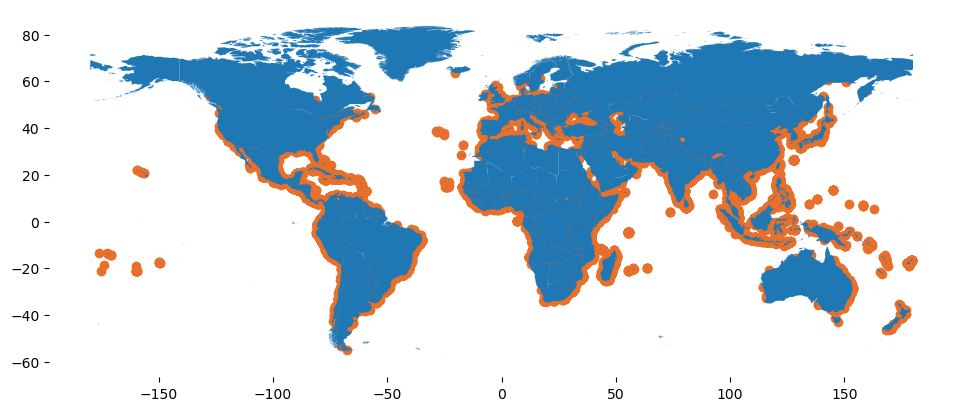

In [95]:
#Plot the points without
fig, ax = plt.subplots()
country_verification.query('WB_ISO.notna()').plot(ax=ax, c = "#e8702a")
world_shapefiles.plot(ax=ax, );

**Now we will do the same exercise by adding a 10 km buffer**

In [96]:
#Add a 10 kilometer buffer
world_shapefiles_buffer = world_shapefiles.to_crs(crs=4087 ) 
world_shapefiles_buffer.geometry =world_shapefiles_buffer.buffer(10000)

In [97]:
#Join the disaster coordinates with their respective country shapefiles
joined_df_geo2 = gpd.GeoDataFrame(
                joined_df, geometry=gpd.points_from_xy(joined_df["long"], joined_df["lat"]), crs="EPSG:4087"
            )

country_verification2 = joined_df_geo2.sjoin(
                world_shapefiles_buffer, how="left", predicate="intersects")

In [98]:
print("There are " + 
    str(country_verification2.query('WB_ISO.isna()').shape[0]) + " disasters outside country shapefiles" )

There are 39859 disasters outside country shapefiles
